In [1]:
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import numpy as np



2024-04-18 16:48:13.425736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 16:48:13.639363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 16:48:13.639393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 16:48:13.677255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 16:48:13.753997: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset_df = pd.read_csv('dataset.csv').to_numpy()
sounds_dataset = dataset_df[:, 0]
sr = 0
for i in range(len(sounds_dataset)):
    sounds_dataset[i], sr = librosa.load(f'Noisy-sounds/{sounds_dataset[i]}.wav')

label_dataset = dataset_df[:, 1]
for i in range(len(label_dataset)):
    label_dataset[i], sr = librosa.load(f'Clean-sounds/{label_dataset[i]}.wav')

X_train, X_test, y_train, y_test = train_test_split(sounds_dataset, label_dataset, test_size=0.1, random_state=42)



In [3]:
print(sr)
def to_spectogram(sound):
    stft = librosa.stft(sound.astype(np.float64), n_fft = 64, hop_length=32)
    stft = np.abs(stft)
    db = librosa.amplitude_to_db(stft, ref=np.max)
    return np.array(db)
    # print(db)
    # librosa.display.specshow(db, y_axis='log', x_axis='time')


22050


In [4]:
spectogram_train = []
for x in X_train:
    spectogram_train.append(to_spectogram(x))
spectogram_label = []
for x in y_train:
    spectogram_label.append(to_spectogram(x))
spectogram_val = []
for x in X_test:
    spectogram_val.append(to_spectogram(x))
spectogram_val_label = []
for x in y_test:
    spectogram_val_label.append(to_spectogram(x))



KeyboardInterrupt: 

In [57]:
X_train_2 = []
y_train_2 = []
X_test_2 = []
y_test_2 = []


(129, 16)
863


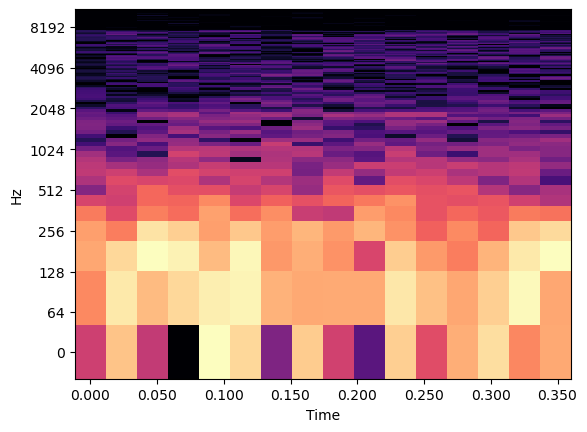

In [7]:
frame_size = 16
max_len = 0
for i in range(0, len(spectogram_train), frame_size):
    crt = []
    vec = spectogram_train[i]
    for j in range(len(vec)):
        crt.append(vec[j][i:i+frame_size])
    X_train_2.append(np.array(crt))
    librosa.display.specshow(X_train_2[0], y_axis='log', x_axis='time')
    print(X_train_2[0].shape)
    break
for x in spectogram_train:
    max_len = max(max_len, len(x[0]))
for x in spectogram_label:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val_label:
    max_len = max(max_len, len(x[0]))
print(max_len)
print(len(spectogram_train[0]))

In [8]:
def pad_vector(vec):
    for i in range(len(vec)):
        vec[i] = np.pad(vec[i], ((0, 0), (0, max_len - len(vec[i][0]))))
    return vec

In [9]:
spectogram_train = pad_vector(spectogram_train)
spectogram_label = pad_vector(spectogram_label)
spectogram_val = pad_vector(spectogram_val)
spectogram_val_label = pad_vector(spectogram_val_label)

spectogram_train = remove_extra(spectogram_train)
spectogram_label = remove_extra(spectogram_label)
spectogram_val = remove_extra(spectogram_val)
spectogram_val_label = remove_extra(spectogram_val_label)


In [10]:
spectogram_train = np.array(spectogram_train)
spectogram_label = np.array(spectogram_label)
spectogram_val = np.array(spectogram_val)
spectogram_val_label = np.array(spectogram_val_label)

In [11]:
spectogram_train = spectogram_train / -80
spectogram_label = spectogram_label / -80
spectogram_val = spectogram_val / -80
spectogram_val_label = spectogram_val_label / -80

In [ ]:
print(spectogram_train.shape)

(5675, 129, 863)


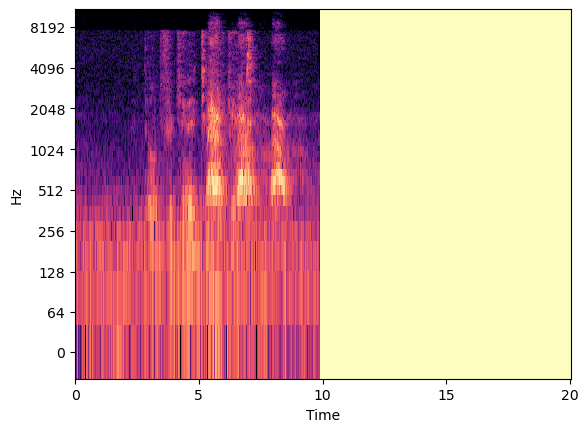

In [ ]:
test = spectogram_train[0] * -80
librosa.display.specshow(test, y_axis='log', x_axis='time')

In [ ]:
print(np.min(spectogram_train[0]), np.max(spectogram_train[0]))

-0.0 1.0


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow import keras
# Define the dimensions of the input data
input_shape = (128, 864, 1)  # MNIST dataset has 28x28 grayscale images

inputs = tf.keras.Input(shape=input_shape)

# Encoder
conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
conv1 = keras.layers.Cropping2D(((0, 1), (0, 7)))(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
conv2 = keras.layers.LeakyReLU()(conv2)
conv2 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
conv2 = keras.layers.LeakyReLU()(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
conv3 = keras.layers.LeakyReLU()(conv3)
conv3 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
conv3 = keras.layers.LeakyReLU()(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
conv4 = keras.layers.LeakyReLU()(conv4)
conv4 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
conv4 = keras.layers.LeakyReLU()(conv4)
drop4 = keras.layers.Dropout(0.5)(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = keras.layers.Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
conv5 = keras.layers.LeakyReLU()(conv5)
conv5 = keras.layers.Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
conv5 = keras.layers.LeakyReLU()(conv5)
drop5 = keras.layers.Dropout(0.5)(conv5)

up6 = keras.layers.Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
up6 = keras.layers.LeakyReLU()(up6)
merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
conv6 = keras.layers.LeakyReLU()(conv6)
conv6 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
conv6 = keras.layers.LeakyReLU()(conv6)
up7 = keras.layers.Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
up7 = keras.layers.LeakyReLU()(up7)
merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
conv7 = keras.layers.LeakyReLU()(conv7)
conv7 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
conv7 = keras.layers.LeakyReLU()(conv7)
up8 = keras.layers.Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
up8 = keras.layers.LeakyReLU()(up8)
merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
conv8 = keras.layers.LeakyReLU()(conv8)
conv8 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
conv8 = keras.layers.LeakyReLU()(conv8)

up9 = keras.layers.Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
up9 = keras.layers.LeakyReLU()(up9)
merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = keras.layers.Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
conv9 = keras.layers.LeakyReLU()(conv9)
conv9 = keras.layers.Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
conv9 = keras.layers.LeakyReLU()(conv9)
conv9 = keras.layers.Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
conv9 = keras.layers.LeakyReLU()(conv9)
conv10 = keras.layers.Conv2D(1, 1, activation = 'tanh')(conv9)



model = Model(inputs=inputs, outputs=conv10)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


2024-04-18 16:50:20.847741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:20.951917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:20.951965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:20.953782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:20.953816: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 129, 863, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 129, 863, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 129, 863, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 cropping2d (Cropping2D)     (None, 128, 856, 64)         0         ['conv2d_1[0][0]']            
                                                                                              

/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:21.083400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:21.083446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 16:50:21.083451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-04-18 16:50:21.083479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000

In [13]:
history = model.fit(spectogram_train, spectogram_label,
                epochs=10,
                batch_size=16,
                shuffle=True,
                validation_data=(spectogram_val, spectogram_val_label),)

Epoch 1/10


2024-04-18 16:50:32.772777: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-18 16:50:32.926916: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 16:50:35.956265: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 16:50:37.283660: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbbc0aa9560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-18 16:50:37.283689: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-18 16:50:37.292454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713448237.347650   53826 device_compiler.

355/355 [==============================] - 94s 215ms/step - loss: 0.0104 - mae: 0.0570 - val_loss: 0.0053 - val_mae: 0.0382
Epoch 2/10
355/355 [==============================] - 63s 176ms/step - loss: 0.0047 - mae: 0.0358 - val_loss: 0.0044 - val_mae: 0.0340
Epoch 3/10
355/355 [==============================] - 62s 174ms/step - loss: 0.0042 - mae: 0.0328 - val_loss: 0.0040 - val_mae: 0.0320
Epoch 4/10
355/355 [==============================] - 63s 179ms/step - loss: 0.0037 - mae: 0.0304 - val_loss: 0.0035 - val_mae: 0.0290
Epoch 5/10
355/355 [==============================] - 62s 176ms/step - loss: 0.0033 - mae: 0.0285 - val_loss: 0.0031 - val_mae: 0.0270
Epoch 6/10
355/355 [==============================] - 62s 174ms/step - loss: 0.0031 - mae: 0.0274 - val_loss: 0.0031 - val_mae: 0.0274
Epoch 7/10
355/355 [==============================] - 64s 180ms/step - loss: 0.0029 - mae: 0.0264 - val_loss: 0.0035 - val_mae: 0.0299
Epoch 8/10
355/355 [==============================] - 63s 179ms/st

In [29]:
sample, sr = librosa.load('Noisy-sounds/Sound2709.wav')
sample = to_spectogram(sample)
sample = np.array(sample)
sample = np.pad(sample, ((0, 0), (0, max_len - len(sample[0]))))
sample = np.expand_dims(sample, axis=0)
sample = sample / -80

prediction = model.predict(sample)

import soundfile as sf
import matplotlib.pyplot as plt
#prediction = librosa.db_to_amplitude(prediction)
prediction = np.squeeze(prediction)
prediction = prediction * -80
prediction = prediction + 3
prediction = librosa.db_to_amplitude(prediction)
prediction = librosa.griffinlim(prediction, hop_length=128, n_fft=256)

sf.write('test_denoised.wav', prediction, sr)

1/1 [==============================] - 0s 12ms/step


In [24]:

print(prediction.shape)
print(np.min(prediction))

1/1 [==============================] - 0s 12ms/step
(1, 129, 863, 1)
0.00015737547


In [18]:
print(np.max(prediction))

1.5693797


0.039145794


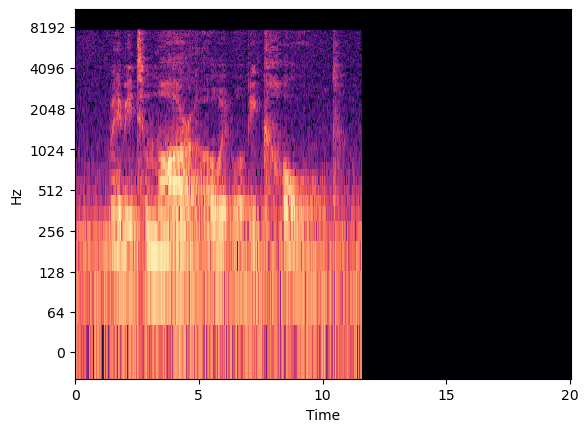

In [26]:
target, sr = librosa.load('Clean-sounds/1087_MTI_DIS_XX.wav')
target = np.pad(target, (0, len(prediction) - len(target)))
print(np.mean((target - prediction)[:60000]))
target = to_spectogram(target)
librosa.display.specshow(target, y_axis='log', x_axis='time')